#Question Answering

###QA with Electra

Источники:
1. Репозиторий https://github.com/xhlulu/covid-qa
2. Оригинальный Notebook https://www.kaggle.com/xhlulu/stackexchange-finetune-electra-small
3. Более подробно про модель ELECTRA https://ai.googleblog.com/2020/03/more-efficient-nlp-model-pre-training.html

We will fine-tune the Electra model with the simplest Q&A mechanism available for transformer models: concatenate the question with the answer, and let the model learn to predict if it is a correct match (label of 1) or incorrect match (label of 0). Ideally, when trained correctly, we want our model to behave this way:

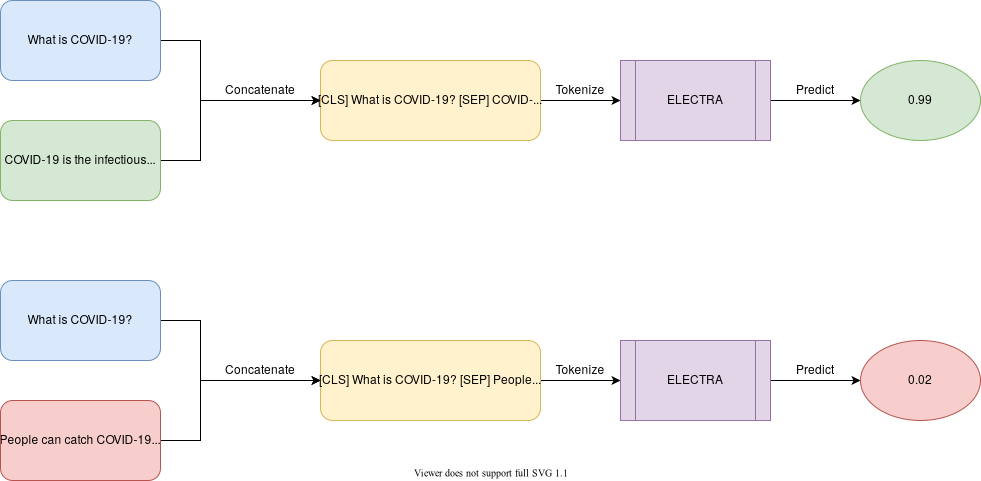

Train model.

NOTE: Switch to TPU!

In [ ]:
# Update to transformers 2.8.0
!pip install -q transformers --upgrade
!pip show transformers


     |████████████████████████████████| 2.9 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 59.9 MB/s 
     |████████████████████████████████| 895 kB 63.7 MB/s 
     |████████████████████████████████| 56 kB 5.8 MB/s 
     |████████████████████████████████| 596 kB 65.3 MB/s 
Name: transformers
Version: 4.11.3
Summary: State-of-the-art Natural Language Processing for TensorFlow 2.0 and PyTorch
Home-page: https://github.com/huggingface/transformers
Author: Thomas Wolf, Lysandre Debut, Victor Sanh, Julien Chaumond, Sam Shleifer, Patrick von Platen, Sylvain Gugger, Suraj Patil, Stas Bekman, Google AI Language Team Authors, Open AI team Authors, Facebook AI Authors, Carnegie Mellon University Authors
Author-email: thomas@huggingface.co
License: Apache
Location: /usr/local/lib/python3.7/dist-packages
Requires: requests, sacremoses, tokenizers, filelock, packaging, regex, tqdm, numpy, importlib-metadata, pyyaml, huggingface-hub
Required-by: 


In [ ]:
import pickle
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt
import transformers
from transformers import AutoTokenizer, TFAutoModel, TFElectraModel, ElectraTokenizer
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [ ]:
tqdm.pandas()

Функция для перевода текстов в последовательность идентификаторов заданного токенизатора. Тексты обрабатываются батчами (размер которых указан в параметре chunk_size) в параллельных потоках, что ускоряет перевод токенов в идентификаторы.  

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512, enable_padding=False):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    
    ---
    
    Inputs:
        tokenizer: the `fast_tokenizer` that we imported from the tokenizers library
    """
    tokenizer.enable_truncation(max_length=maxlen)
    if enable_padding:
        tokenizer.enable_padding(max_length=maxlen)
    
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

Функция формирует строку вида: "[CLS] вопрос [SEP] ответ [SEP]" в формате идентификаторов токенов и добавляет паддинг в конце строки.

In [ ]:
def combine_qa_ids(q_ids, a_ids, tokenizer, maxlen=512):
    """
    Given two arrays of IDs (questions and answers) created by
    `fast_encode`, we combine and pad them.
    Inputs:
        tokenizer: The original tokenizer (not the fast_tokenizer)
    """
    combined_ids = []

    for i in tqdm(range(q_ids.shape[0])):
        ids = []
        # ids.append(tokenizer.cls_token_id)
        ids.extend(q_ids[i])
        # ids.append(tokenizer.sep_token_id)
        ids.extend(a_ids[i][1:]) # remove [CLS] token
        # ids.append(tokenizer.sep_token_id)
        ids.extend([tokenizer.pad_token_id] * (maxlen - len(ids)))

        combined_ids.append(ids)
    
    return np.array(combined_ids)

Функция, создающая модель, состоящую из слоев Трансформера и полносвязного слоя для решения задачи. В качестве параметра transformer можно передать любую модель из библиотеки transformers от Hugging Face.

In [ ]:
def build_model(transformer, max_len=None):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_ids = L.Input(shape=(max_len, ), dtype=tf.int32)
    
    x = transformer(input_ids)[0]
    x = x[:, 0, :]
    x = L.Dense(1, activation='sigmoid', name='sigmoid')(x)
    
    # BUILD AND COMPILE MODEL
    model = Model(inputs=input_ids, outputs=x)
    model.compile(
        loss='binary_crossentropy', 
        metrics=['accuracy'], 
        optimizer=Adam(lr=1e-5)
    )
    
    return model

TPU Configs

In [ ]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running on TPU  grpc://10.64.179.114:8470
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.64.179.114:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.64.179.114:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
EPOCHS = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 512
MODEL = 'google/electra-small-discriminator'

Load data

Data is available here https://www.kaggle.com/xhlulu/stackexchange-qa-pairs

For simplicity, we consider only biomedical part.

In [ ]:
! mkdir pre_covid
! wget https://www.dropbox.com/s/1y9yst4po7y0ezw/biomedical.csv?dl=0 -O pre_covid/biomedical.csv

--2021-10-28 11:46:41--  https://www.dropbox.com/s/1y9yst4po7y0ezw/biomedical.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/1y9yst4po7y0ezw/biomedical.csv [following]
--2021-10-28 11:46:41--  https://www.dropbox.com/s/raw/1y9yst4po7y0ezw/biomedical.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc639e8b16232fa8974543383d2d.dl.dropboxusercontent.com/cd/0/inline/BY7-upfzvRldK88eJI7rOKP-DVhILxSA9PZWrA3j6CEHiQiIH4ETPhf9CqVwWQ-xXGYp3hGAiGp3rIIabTxR2DfT10oxvhzSjaE-83G5t3ixDDBEN8ke7kOLnIsS5vTCZXVq71cqkD7TYCP_dKEfMfVs/file# [following]
--2021-10-28 11:46:42--  https://uc639e8b16232fa8974543383d2d.dl.dropboxusercontent.com/cd/0/inline/BY7-upfzvRldK88eJI7rOKP-DVhILxSA9PZWrA3j6CEHiQiIH4ETPhf9CqVwWQ-xXGYp3hGAiGp3rII

In [ ]:
df = pd.concat([
    pd.read_csv(f'pre_covid/{group}.csv')
    #for group in ['expert', 'biomedical', 'general']
    for group in ['biomedical']
]).reset_index(drop=True)

df.head()

,Unnamed: 0,question_id,title,question,answer_id,answer,answer_type,wrong_answer,wrong_answer_type,site,group
0,0,13408,Why are interspecies hybrids so often larger t...,Recently doing a little reading on interspecie...,13409,While they do not necessarily constitute the m...,Accepted,My initial guess (knowing almost no informatio...,Random,biology,biomedical
1,1,13412,Body's decomposition,Does a human body decompose in a completely st...,13424,\n Does a human body decompose in a completel...,Accepted,In the pictures shown above only the soft part...,Random,biology,biomedical
2,2,13414,A weird-looking fish with a shield,I found this photo in a local news page. The p...,13443,The front part of the fish looks like part of ...,Accepted,The delay in immune attack is common for many ...,Random,biology,biomedical
3,3,13421,Why does caffeine consumption cause one to uri...,What is the physiological mechanism behind the...,13431,Caffeine inhibits the secretion of the antidiu...,Accepted,Short answer\nThe dopamine hypothesis includes...,Random,biology,biomedical
4,4,13425,Telomere shortening during replication,It is widely know that each cell cycle during ...,13434,"In replication, both the chromosomal halves (w...",Accepted,To expand on my comments:\n\nJust like you men...,Random,biology,biomedical


In [ ]:
questions = df.title + "[SEP]" + df.question

Bert tokenizer

In [ ]:
# First load the real tokenizer
tokenizer = ElectraTokenizer.from_pretrained(MODEL)
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

DEBUG:filelock:Attempting to acquire lock 139720624961552 on /root/.cache/huggingface/transformers/ece45ade3e01224cf31fed8e183b306d17b84e8abd415363474cfe72274f7814.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock
DEBUG:filelock:Lock 139720624961552 acquired on /root/.cache/huggingface/transformers/ece45ade3e01224cf31fed8e183b306d17b84e8abd415363474cfe72274f7814.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139720624961552 on /root/.cache/huggingface/transformers/ece45ade3e01224cf31fed8e183b306d17b84e8abd415363474cfe72274f7814.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock
DEBUG:filelock:Lock 139720624961552 released on /root/.cache/huggingface/transformers/ece45ade3e01224cf31fed8e183b306d17b84e8abd415363474cfe72274f7814.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock
DEBUG:filelock:Attempting to acquire lock 139719787109264 on /root/.cache/huggingface/transformers/8b3aea9f7242b3d19268df5b1bfed8f66e08671a72ac0809ada08e5ef1adc592.19eda9a6da5fb0e52a45200c95876729561dde16a69b9116953af6edca1d1e92.lock
DEBUG:filelock:Lock 139719787109264 acquired on /root/.cache/huggingface/transformers/8b3aea9f7242b3d19268df5b1bfed8f66e08671a72ac0809ada08e5ef1adc592.19eda9a6da5fb0e52a45200c95876729561dde16a69b9116953af6edca1d1e92.lock


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139719787109264 on /root/.cache/huggingface/transformers/8b3aea9f7242b3d19268df5b1bfed8f66e08671a72ac0809ada08e5ef1adc592.19eda9a6da5fb0e52a45200c95876729561dde16a69b9116953af6edca1d1e92.lock
DEBUG:filelock:Lock 139719787109264 released on /root/.cache/huggingface/transformers/8b3aea9f7242b3d19268df5b1bfed8f66e08671a72ac0809ada08e5ef1adc592.19eda9a6da5fb0e52a45200c95876729561dde16a69b9116953af6edca1d1e92.lock
DEBUG:filelock:Attempting to acquire lock 139720601678864 on /root/.cache/huggingface/transformers/92992b36de47dee64b1d5a31c05d8d51e3075b918a218f5ba4f6e306c4b81b8c.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock
DEBUG:filelock:Lock 139720601678864 acquired on /root/.cache/huggingface/transformers/92992b36de47dee64b1d5a31c05d8d51e3075b918a218f5ba4f6e306c4b81b8c.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock


Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139720601678864 on /root/.cache/huggingface/transformers/92992b36de47dee64b1d5a31c05d8d51e3075b918a218f5ba4f6e306c4b81b8c.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock
DEBUG:filelock:Lock 139720601678864 released on /root/.cache/huggingface/transformers/92992b36de47dee64b1d5a31c05d8d51e3075b918a218f5ba4f6e306c4b81b8c.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock
DEBUG:filelock:Attempting to acquire lock 139720601680336 on /root/.cache/huggingface/transformers/ca13c16218c6780ec76753d3afa19fcb7cc759e3f63ee87e441562d374762b3d.3dd1921e571dfa18c0bdaa17b9b38f111097812281989b1cb22263738e66ef73.lock
DEBUG:filelock:Lock 139720601680336 acquired on /root/.cache/huggingface/transformers/ca13c16218c6780ec76753d3afa19fcb7cc759e3f63ee87e441562d374762b3d.3dd1921e571dfa18c0bdaa17b9b38f111097812281989b1cb22263738e66ef73.lock


Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139720601680336 on /root/.cache/huggingface/transformers/ca13c16218c6780ec76753d3afa19fcb7cc759e3f63ee87e441562d374762b3d.3dd1921e571dfa18c0bdaa17b9b38f111097812281989b1cb22263738e66ef73.lock
DEBUG:filelock:Lock 139720601680336 released on /root/.cache/huggingface/transformers/ca13c16218c6780ec76753d3afa19fcb7cc759e3f63ee87e441562d374762b3d.3dd1921e571dfa18c0bdaa17b9b38f111097812281989b1cb22263738e66ef73.lock


Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

Convert text to matrices

Caveat: Since a lot of the questions on stackexchange goes over 256, characters, we end up truncating a large part (if not all) of the answers. Thus, we need to "pre" truncate them by separately encode the questions and answers, and use a functions to combine them again.

In [ ]:
q_ids = fast_encode(questions.values, fast_tokenizer, maxlen=MAX_LEN//2 - 2)
print(q_ids[0])
a_ids = fast_encode(df.answer.values, fast_tokenizer, maxlen=MAX_LEN//2 - 2)
wa_ids = fast_encode(df.wrong_answer.values, fast_tokenizer, maxlen=MAX_LEN//2 - 2)

correct_ids = combine_qa_ids(q_ids, a_ids, tokenizer, maxlen=MAX_LEN)
wrong_ids = combine_qa_ids(q_ids, wa_ids, tokenizer, maxlen=MAX_LEN)

  0%|          | 0/81 [00:00<?, ?it/s]

[101, 2339, 2024, 6970, 13102, 8586, 3111, 23376, 2061, 2411, 3469, 2084, 2593, 6687, 2427, 102, 3728, 2725, 1037, 2210, 3752, 2006, 6970, 13102, 8586, 3111, 23376, 1045, 4384, 2008, 2009, 3849, 6970, 13102, 8586, 3111, 23376, 2024, 2087, 2411, 2172, 3469, 2084, 2593, 6687, 1012, 5546, 1010, 5622, 15776, 1010, 1040, 6844, 1998, 10891, 8870, 1010, 2021, 2009, 3849, 2066, 2035, 2030, 2012, 2560, 2087, 1012, 2003, 2045, 1037, 3114, 2005, 2023, 7403, 3670, 1999, 23376, 1029, 2065, 1045, 2572, 19721, 1999, 7512, 4892, 2023, 2000, 2022, 1996, 2553, 2292, 2033, 2113, 2008, 2612, 1012, 102]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/20701 [00:00<?, ?it/s]

  0%|          | 0/20701 [00:00<?, ?it/s]

In [ ]:
print(correct_ids[0])

[  101  2339  2024  6970 13102  8586  3111 23376  2061  2411  3469  2084
  2593  6687  2427   102  3728  2725  1037  2210  3752  2006  6970 13102
  8586  3111 23376  1045  4384  2008  2009  3849  6970 13102  8586  3111
 23376  2024  2087  2411  2172  3469  2084  2593  6687  1012  5546  1010
  5622 15776  1010  1040  6844  1998 10891  8870  1010  2021  2009  3849
  2066  2035  2030  2012  2560  2087  1012  2003  2045  1037  3114  2005
  2023  7403  3670  1999 23376  1029  2065  1045  2572 19721  1999  7512
  4892  2023  2000  2022  1996  2553  2292  2033  2113  2008  2612  1012
   102  2096  2027  2079  2025  9352 12346  1996  3484  1010  2009  2003
  2995  2008  2045  2003  1037  2312  2193  1997  6970 13102  8586  3111
 23376  3005  2372  2024  3469  1999  2946  2084  1996  6687  2427  1010
  1998  2045  4839 17959  2008  4070  2005  2023  9575  1012  2054  2017
  2024  7851  2003  2019  2742  1997  3893 21770 27360  2483  1010  2030
  8893 24474  1012  2096  1996 11581  2063  2005  4

In [ ]:
input_ids = np.concatenate([correct_ids, wrong_ids])

labels = np.concatenate([
    np.ones(correct_ids.shape[0]),
    np.zeros(wrong_ids.shape[0])
]).astype(np.int32)

Train test split

In [ ]:
train_idx, test_idx = train_test_split(
    np.arange(input_ids.shape[0]), 
    test_size=0.3, 
    random_state=0
)

valid_idx, test_idx = train_test_split(
    test_idx, 
    test_size=0.5, 
    random_state=1
)

In [ ]:
train_ids = input_ids[train_idx]
valid_ids = input_ids[valid_idx]
test_ids = input_ids[test_idx]

train_labels = labels[train_idx]
valid_labels = labels[valid_idx]
test_labels = labels[test_idx]

Build datasets objects

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_ids, train_labels))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_ids, valid_labels))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_ids)
    .batch(BATCH_SIZE)
)

Modeling

In [ ]:
%%time
with strategy.scope():
    transformer_layer = TFElectraModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

DEBUG:filelock:Attempting to acquire lock 139719775431696 on /root/.cache/huggingface/transformers/5ebd9867bcaf9f212165e7dc027bd49ccb74e18da95b68b04ab2048cbe968098.e8e924e2e78e44d9a42e833b4b0595464e280c67cd6ccb3bd06dd7e1163a0244.h5.lock
DEBUG:filelock:Lock 139719775431696 acquired on /root/.cache/huggingface/transformers/5ebd9867bcaf9f212165e7dc027bd49ccb74e18da95b68b04ab2048cbe968098.e8e924e2e78e44d9a42e833b4b0595464e280c67cd6ccb3bd06dd7e1163a0244.h5.lock


Downloading:   0%|          | 0.00/51.9M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139719775431696 on /root/.cache/huggingface/transformers/5ebd9867bcaf9f212165e7dc027bd49ccb74e18da95b68b04ab2048cbe968098.e8e924e2e78e44d9a42e833b4b0595464e280c67cd6ccb3bd06dd7e1163a0244.h5.lock
DEBUG:filelock:Lock 139719775431696 released on /root/.cache/huggingface/transformers/5ebd9867bcaf9f212165e7dc027bd49ccb74e18da95b68b04ab2048cbe968098.e8e924e2e78e44d9a42e833b4b0595464e280c67cd6ccb3bd06dd7e1163a0244.h5.lock
Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a Ber

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
tf_electra_model (TFElectraM TFBaseModelOutput(last_hi 13483008  
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 256)               0         
_________________________________________________________________
sigmoid (Dense)              (None, 1)                 257       
Total params: 13,483,265
Trainable params: 13,483,265
Non-trainable params: 0
_________________________________________________________________
CPU times: user 13.3 s, sys: 2.27 s, total: 15.6 s
Wall time: 18.5 s


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Train model

In [ ]:
n_steps = train_labels.shape[0] // BATCH_SIZE

train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/3


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int32>]


226/226 [==============================] - ETA: 0s - loss: 0.6103 - accuracy: 0.6442

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int32>]


226/226 [==============================] - 111s 220ms/step - loss: 0.6103 - accuracy: 0.6442 - val_loss: 0.4441 - val_accuracy: 0.7982
Epoch 2/3
226/226 [==============================] - 31s 137ms/step - loss: 0.3757 - accuracy: 0.8395 - val_loss: 0.3331 - val_accuracy: 0.8699
Epoch 3/3
226/226 [==============================] - 31s 136ms/step - loss: 0.3038 - accuracy: 0.8788 - val_loss: 0.3072 - val_accuracy: 0.8818


In [ ]:
hist_df = pd.DataFrame(train_history.history)
hist_df.to_csv('train_history.csv')
hist_df

,loss,accuracy,val_loss,val_accuracy
0,0.658937,0.598901,0.521758,0.751530
1,0.415082,0.815749,0.363402,0.847826
2,0.318064,0.872477,0.299428,0.885990
3,0.274490,0.893944,0.278525,0.899839
4,0.245364,0.908739,0.266268,0.905475
5,0.227651,0.916690,0.255115,0.908857
6,0.215068,0.921253,0.257032,0.908374
7,0.202407,0.926576,0.269754,0.909501


Eval

In [ ]:
y_score = model.predict(test_dataset, verbose=1).squeeze()
y_pred = y_score.round().astype(int)
print("AP:", average_precision_score(test_labels, y_score))
print("ROC AUC:", roc_auc_score(test_labels, y_score))
print(classification_report(test_labels, y_pred))

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>]


49/49 [==============================] - 21s 352ms/step
AP: 0.9248921009861325
ROC AUC: 0.9468101564824982
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      3121
           1       0.84      0.96      0.90      3090

    accuracy                           0.89      6211
   macro avg       0.90      0.89      0.89      6211
weighted avg       0.90      0.89      0.89      6211



###JointBERT for Joint Intent Classification and Slot Filling

NOTE: Switch to GPU!

Intent classification focuses on predicting the intent
of the query, while slot filling extracts semantic
concepts.

Репозиторий с исходным кодом: https://github.com/monologg/JointBERT

Загружаем код и данные из репозитория, устанавливаем необходимые библиотеки.

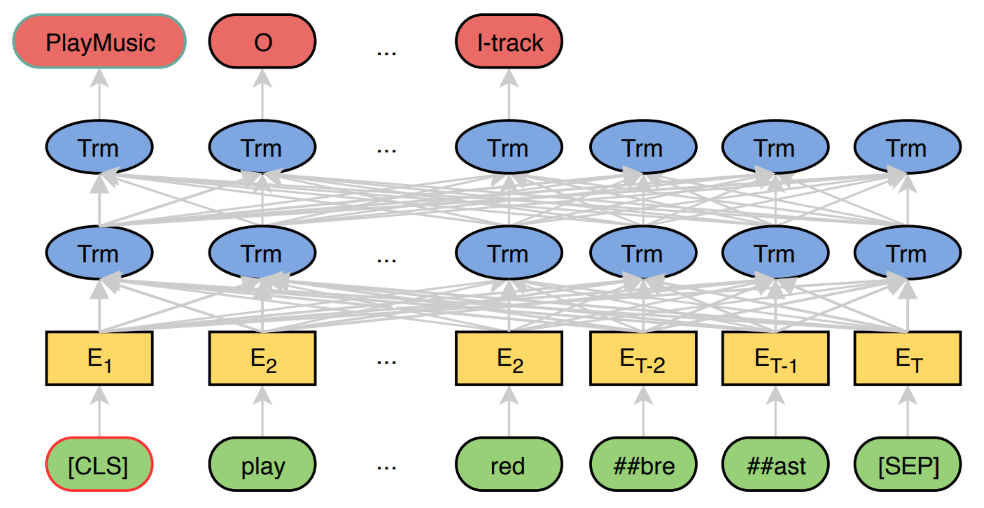

In [ ]:
! wget https://github.com/monologg/JointBERT/archive/master.zip
! unzip master.zip
! pip install -r JointBERT-master/requirements.txt

--2021-10-28 11:27:31--  https://github.com/monologg/JointBERT/archive/master.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/monologg/JointBERT/zip/master [following]
--2021-10-28 11:27:31--  https://codeload.github.com/monologg/JointBERT/zip/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [ <=>                ] 436.58K  --.-KB/s    in 0.09s   

2021-10-28 11:27:31 (4.80 MB/s) - ‘master.zip’ saved [447055]

Archive:  master.zip
00324f60dda4a491b2913bc3065ae93966caea3f
   creating: JointBERT-master/
  inflating: JointBERT-master/.gitignore  
  inflating: JointBERT-master/L

Тексты запрсов.

In [ ]:
! head -10 JointBERT-master/data/snips/train/seq.in

listen to westbam alumb allergic on google music
add step to me to the 50 clásicos playlist 
i give this current textbook a rating value of 1 and a best rating of 6
play the song little robin redbreast
please add iris dement to my playlist this is selena
add slimm cutta calhoun to my this is prince playlist  
i want to listen to seventies music 
play a popular chant by brian epstein
find fish story 
book a spot for 3 in mt


Examples of the slots.

In [ ]:
! head -10 JointBERT-master/data/snips/train/seq.out

O O B-artist O B-album O B-service I-service 
O B-entity_name I-entity_name I-entity_name O O B-playlist I-playlist O 
O O O B-object_select B-object_type O O O O B-rating_value O O O O O B-best_rating 
O O B-music_item B-track I-track I-track 
O O B-artist I-artist O B-playlist_owner O B-playlist I-playlist I-playlist 
O B-artist I-artist I-artist O B-playlist_owner B-playlist I-playlist I-playlist O 
O O O O O B-year O 
O O B-sort B-music_item O B-artist I-artist 
O B-movie_name I-movie_name 
O O O O B-party_size_number O B-state 


Examples of the intents.

In [ ]:
! head -10 JointBERT-master/data/snips/train/label

PlayMusic
AddToPlaylist
RateBook
PlayMusic
AddToPlaylist
AddToPlaylist
PlayMusic
PlayMusic
SearchScreeningEvent
BookRestaurant


We reduce dataset to faster training process.

In [ ]:
def cut_dataset(input_dir, output_dir, labels, num_examples=1000):

  seq_in = open(os.path.join(input_dir, "seq.in")).readlines()
  seq_out = open(os.path.join(input_dir,"seq.out")).readlines()
  labels = open(os.path.join(input_dir,"label")).readlines()

  df = pd.DataFrame({"seq_in": seq_in, "seq_out": seq_out, "labels": labels})
  df = df.loc[(df['labels'] == "AddToPlaylist\n") | (df['labels'] == "BookRestaurant\n")]
  print(df.shape)
  df = df[:num_examples]
  print(df.shape)
  open(os.path.join(output_dir, "seq.in"), "w").writelines(df.seq_in.values[:num_examples])
  open(os.path.join(output_dir, "seq.out"), "w").writelines(df.seq_out.values[:num_examples])
  open(os.path.join(output_dir,"label"), "w").writelines(df.labels.values[:num_examples])

In [ ]:
! mkdir JointBERT-master/data_small/
! mkdir JointBERT-master/data_small/snips
! mkdir JointBERT-master/data_small/snips/train
! mkdir JointBERT-master/data_small/snips/dev
! mkdir JointBERT-master/data_small/snips/test
! cp JointBERT-master/data/snips/intent_label.txt JointBERT-master/data_small/snips/intent_label.txt 
! cp JointBERT-master/data/snips/slot_label.txt JointBERT-master/data_small/snips/slot_label.txt 

In [ ]:
cut_dataset("JointBERT-master/data/snips/train/", "JointBERT-master/data_small/snips/train/", labels=["AddToPlaylist", "BookRestaurant"])
cut_dataset("JointBERT-master/data/snips/dev/", "JointBERT-master/data_small/snips/dev/", labels=["AddToPlaylist", "BookRestaurant"])
cut_dataset("JointBERT-master/data/snips/test/", "JointBERT-master/data_small/snips/test/", labels=["AddToPlaylist", "BookRestaurant"])

(3699, 3)
(1000, 3)
(200, 3)
(200, 3)
(216, 3)
(216, 3)


The source code of model https://github.com/monologg/JointBERT/blob/master/model/modeling_jointdistilbert.py

Train model. You can also put crf on top, however, this will significantly increase the training time.

In [ ]:
! python3 JointBERT-master/main.py --task snips \
                  --model_type distilbert \
                  --model_dir snips_model \
                  --data_dir JointBERT-master/data_small/ \
                  --num_train_epoch 3 \
                  --save_steps 20 \
                  --logging_steps 20\
                  --do_train --do_eval 
                  #--use_crf

10/28/2021 11:40:05 - INFO - transformers.tokenization_utils_base -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
10/28/2021 11:40:05 - INFO - data_loader -   Loading features from cached file JointBERT-master/data_small/cached_train_snips_distilbert-base-uncased_50
10/28/2021 11:40:05 - INFO - data_loader -   Loading features from cached file JointBERT-master/data_small/cached_dev_snips_distilbert-base-uncased_50
10/28/2021 11:40:05 - INFO - data_loader -   Loading features from cached file JointBERT-master/data_small/cached_test_snips_distilbert-base-uncased_50
10/28/2021 11:40:05 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-config.json from cache at /root/.cac

Predicting intents and slots on test set.

In [ ]:
! python3 JointBERT-master/predict.py \
  --input_file JointBERT-master/data_small/snips/test/seq.in \
  --output_file JointBERT-master/data_small/snips/pred \
  --model_dir snips_model

10/28/2021 11:40:30 - INFO - transformers.configuration_utils -   loading configuration file snips_model/config.json
10/28/2021 11:40:30 - INFO - transformers.configuration_utils -   Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "JointDistilBERT"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "snips",
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "vocab_size": 30522
}

10/28/2021 11:40:30 - INFO - transformers.modeling_utils -   loading weights file snips_model/pytorch_model.bin
10/28/2021 11:40:31 - INFO - transformers.modeling_utils -   All model checkpoint weights were used when initializing JointDistilBERT.

10/28/2021 11:40:31 - INFO - transformers.modeling_utils -   All the wei

In [ ]:
! head -10 JointBERT-master/data_small/snips/pred

<AddToPlaylist> -> add [sabrina:B-artist] [salerno:I-artist] to the [grime:B-playlist] [instrumentals:I-playlist] playlist
<BookRestaurant> -> i want to bring [four:B-party_size_number] people to a place that s close to [downtown:B-state] that serves [churrascaria:B-city] cuisine
<AddToPlaylist> -> put [lindsey:B-artist] [cardinale:I-artist] into [my:B-playlist_owner] [hillary:B-playlist] [clinton:I-playlist] [s:I-playlist] [women:I-playlist] [s:I-playlist] [history:I-playlist] [month:I-playlist] playlist
<BookRestaurant> -> can you get me reservations for a [highly:B-restaurant_type] [rated:B-restaurant_type] [restaurant:B-restaurant_type] in [seychelles:B-country]
<BookRestaurant> -> on [june:I-timeRange] [27:I-timeRange] [2026:I-timeRange] i d like to go to a [delaware:B-state] [gastropub:B-restaurant_type]
<BookRestaurant> -> make a reservation at a [bakery:B-restaurant_type] that has [acquacotta:I-restaurant_name] in [central:B-country] [african:B-country] [republic:B-country] for

### Question Answering with SQuAD 2.0 and Transformers

Question Answering on SQuAD dataset is a task to find an answer on question in a given context (e.g, paragraph from Wikipedia), where the answer to each question is a segment of the context. 

Source code https://huggingface.co/transformers/custom_datasets.html#question-answering-with-squad-2-0.

We will start by downloading the data:

In [ ]:
!mkdir squad
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

--2021-10-28 12:02:50--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘squad/train-v2.0.json’

squad/train-v2.0.js 100%[===================>]  40.17M   236MB/s    in 0.2s    

2021-10-28 12:02:52 (236 MB/s) - ‘squad/train-v2.0.json’ saved [42123633/42123633]

--2021-10-28 12:02:52--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘squad/dev-v2.0.json’

squ

Each split is in a structured json file with a number of questions and answers for each passage (or context). We’ll take this apart into parallel lists of contexts, questions, and answers (note that the contexts here are repeated since there are multiple questions per context):

In [ ]:
import json
from pathlib import Path

def read_squad(path):
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return contexts, questions, answers

train_contexts, train_questions, train_answers = read_squad('squad/train-v2.0.json')
val_contexts, val_questions, val_answers = read_squad('squad/dev-v2.0.json')

The contexts and questions are just strings. The answers are dicts containing the subsequence of the passage with the correct answer as well as an integer indicating the character at which the answer begins. In order to train a model on this data we need (1) the tokenized context/question pairs, and (2) integers indicating at which token positions the answer begins and ends.

In [ ]:
print(train_contexts[0])
print(train_questions[0])
print(train_answers[0])

Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
When did Beyonce start becoming popular?
{'text': 'in the late 1990s', 'answer_start': 269}


Reducing dataset to faster training.

In [ ]:
TRAIN_EXAMPLES_NUM = 500
VAL_EXAMPLES_NUM = 20

train_contexts = train_contexts[:TRAIN_EXAMPLES_NUM]
train_questions = train_questions[:TRAIN_EXAMPLES_NUM]
train_answers = train_answers[:TRAIN_EXAMPLES_NUM]

val_contexts = val_contexts[:VAL_EXAMPLES_NUM]
val_questions = val_questions[:VAL_EXAMPLES_NUM]
val_answers = val_answers[:VAL_EXAMPLES_NUM]

First, let’s get the character position at which the answer ends in the passage (we are given the starting position). Sometimes SQuAD answers are off by one or two characters, so we will also adjust for that.

In [ ]:
def add_end_idx(answers, contexts):
  for answer, context in zip(answers, contexts):
    gold_text = answer['text']
    start_idx = answer['answer_start']
    end_idx = start_idx + len(gold_text)

    # sometimes squad answers are off by a character or two – fix this
    if context[start_idx:end_idx] == gold_text:
        answer['answer_end'] = end_idx
    elif context[start_idx-1:end_idx-1] == gold_text:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
    elif context[start_idx-2:end_idx-2] == gold_text:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters

add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

In [ ]:
train_answers[0]

{'answer_end': 286, 'answer_start': 269, 'text': 'in the late 1990s'}

Now train_answers and val_answers include the character end positions and the corrected start positions. Next, let’s tokenize our context/question pairs. 🤗 Tokenizers can accept parallel lists of sequences and encode them together as sequence pairs.

In [ ]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

Next we need to convert our character start/end positions to token start/end positions. When using 🤗 Fast Tokenizers, we can use the built in char_to_token() method.

In [ ]:
def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []
  for i in range(len(answers)):
      start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
      end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))
      # if None, the answer passage has been truncated
      if start_positions[-1] is None:
          start_positions[-1] = tokenizer.model_max_length
      if end_positions[-1] is None:
          end_positions[-1] = tokenizer.model_max_length
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

Our data is ready. Let’s just put it in a PyTorch/TensorFlow dataset so that we can easily use it for training. In PyTorch, we define a custom Dataset class. In TensorFlow, we pass a tuple of (inputs_dict, labels_dict) to the from_tensor_slices method.

In [ ]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

Now we can use a DistilBert model with a QA head for training:

In [ ]:
from transformers import DistilBertForQuestionAnswering
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

The data and model are both ready to go. You can train the model with Trainer/TFTrainer exactly as in the sequence classification example above. If using native PyTorch, replace labels with start_positions and end_positions in the training example. If using Keras’s fit, we need to make a minor modification to handle this example since it involves multiple model outputs.

In [ ]:
from torch.utils.data import DataLoader
from transformers import AdamW

NUM_EPOCHS = 3

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

for epoch in range(NUM_EPOCHS):
    print("Epoch %s of %s" %(epoch + 1, NUM_EPOCHS))
    i = 0
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        loss.backward()
        optim.step()
        i += 1

model.eval()

Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3


DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            

Fine-tuning with Trainer https://huggingface.co/transformers/custom_datasets.html#ft-trainer.

###DPR

Рассмотрим примеры применения предобученной модели [DPR](https://huggingface.co/transformers/model_doc/dpr.html) (Dense Passage Retrieval). DPR использует два независимых кодировщика на основе BERT для получения представлений абзацев и вопросов, а затем вычисляет меру близости между полученными векторами. В huggingface представлена модель, предобученная на корпусе NQ (Natural Questions). 

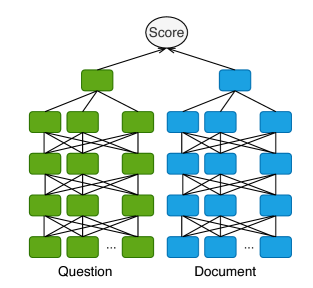

Инициализируем модель и токенизатор, закодируем вопрос и абзац, в котором будем искать ответ.

In [ ]:
!pip install transformers

     |████████████████████████████████| 15.7 MB 5.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 0.18.2 requires pandas>=1.0, but you have pandas 0.24.2 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.6.0 which is incompatible.
tensorflow-probability 0.14.1 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
spacy 2.2.4 requires tqdm<5.0.0,>=4.38.0, but you have tqdm 4.32.2 which is incompatible.
plotnine 0.6.0 requires pandas>=0.25.0, but you have pandas 0.24.2 which is incompatible.
mizani 0.6.0 requires pandas>=0.25.0, but you have pandas 0.24.2 which is incompatible.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 1.14.0 whic

In [ ]:
from transformers import DPRReader, DPRReaderTokenizer
tokenizer = DPRReaderTokenizer.from_pretrained('facebook/dpr-reader-single-nq-base')
model = DPRReader.from_pretrained('facebook/dpr-reader-single-nq-base')
encoded_inputs = tokenizer(
        questions=["What is love ?"],
        titles=["Haddaway"],
        texts=["'What Is Love' is a song recorded by the artist Haddaway"],
        return_tensors='pt'
    )

/usr/local/lib/python3.7/dist-packages/cryptography/hazmat/backends/openssl/x509.py:18: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


Подадим на вход модели полученные представления, на выходе модели для каждого токена получим оценки того, что данный токен является началом ответа или концом ответа, а также степени релевантности заданного вопроса к ответу.

In [ ]:
outputs = model(**encoded_inputs)

start_logits = outputs.start_logits
end_logits = outputs.end_logits
relevance_logits = outputs.relevance_logits
print(relevance_logits)

tensor([-1.2456], grad_fn=<ViewBackward>)


Получим индексы токенов с наиболее вероятными значениями начала и конца вопроса:

In [ ]:
answer_start = torch.argmax(start_logits)  # Get the most likely beginning of answer with the argmax of the score
answer_end = torch.argmax(end_logits) + 1  # Get the most likely end of answer with the argmax of the score

Сформируем итоговый ответ в виде стороки:

In [ ]:
answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(encoded_inputs['input_ids'][0][answer_start:answer_end]))

# print(f"Question: {question}")
print(f"Answer: {answer}\n")

Answer: a song



Рассмотрим пример с несколькими вопросами для одного абзаца, для этого в модель нужно передать список вопросов, пассажей и заголовков:

In [ ]:
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""

questions = [
    "How many pretrained models are available in Transformers?",
    "What does Transformers provide?",
    "Transformers provides interoperability between which frameworks?",
]

title = "Transformers"

encoded_inputs = tokenizer(
        questions=questions,
        titles=[title] * 3,
        texts=[text] * 3,
        return_tensors='pt',
        truncation=True,
        padding=True
    )
outputs = model(**encoded_inputs)
answer_start_scores = outputs["start_logits"]
answer_end_scores = outputs["end_logits"]

answer_starts = torch.argmax(answer_start_scores, dim=1)  # Get the most likely beginning of answer with the argmax of the score
answer_ends = torch.argmax(answer_end_scores, dim=1) + 1  # Get the most likely end of answer with the argmax of the score

answers = [tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(encoded_inputs['input_ids'][0][answer_start:answer_end])) \
          for answer_start, answer_end in zip(answer_starts, answer_ends)]

for question, answer in zip(questions, answers):
    print(f"Question: {question}")
    print(f"Answer: {answer}\n")

Question: How many pretrained models are available in Transformers?
Answer: over 32 +

Question: What does Transformers provide?
Answer: ##trained - bert )

Question: Transformers provides interoperability between which frameworks?
Answer: provides general - purpose architecture



### Deeppavlov and SberQUAD

Источник: https://medium.com/deeppavlov/developing-qa-systems-for-any-language-with-deeppavlov-a9033d5231a8

In [ ]:
!pip install deeppavlov

In [ ]:
!python -m deeppavlov install squad_ru_rubert_infer

2021-10-28 14:33:01.784 INFO in 'deeppavlov.core.common.file'['file'] at line 30: Interpreting 'squad_ru_rubert_infer' as '/usr/local/lib/python3.7/dist-packages/deeppavlov/configs/squad/squad_ru_rubert_infer.json'
  Cloning https://github.com/deepmipt/bert.git (to revision feat/multi_gpu) to /tmp/pip-req-build-ahtq31a7
  Running command git clone -q https://github.com/deepmipt/bert.git /tmp/pip-req-build-ahtq31a7


In [ ]:
from deeppavlov import build_model, configs

model_qa = build_model(configs.squad.squad_ru_rubert_infer, download=True)
model_qa(["Атмосфе́рные оса́дки (также — гидрометео́ры) — атмосферные явления, \
связанные с присутствием в атмосфере воды в жидком или твёрдом состоянии, \
выпадающей из облаков или осаждающейся из воздуха на земную поверхность и какие-либо предметы."],
         ["Куда осаждается вода?"])

/usr/local/lib/python3.7/dist-packages/cryptography/hazmat/backends/openssl/x509.py:18: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,
2021-10-28 14:33:12.805 INFO in 'deeppavlov.download'['download'] at line 116: Skipped http://files.deeppavlov.ai/deeppavlov_data/squad_model_ru_rubert.tar.gz download because of matching hashes
2021-10-28 14:33:14.956 INFO in 'deeppavlov.download'['download'] at line 116: Skipped http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_v1.tar.gz download because of matching hashes
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date

Using TensorFlow backend.


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


2021-10-28 14:33:39.522 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 52: [loading model from /root/.deeppavlov/models/squad_ru_bert/model_rubert]



INFO:tensorflow:Restoring parameters from /root/.deeppavlov/models/squad_ru_bert/model_rubert


[['на земную поверхность'], [192], [253907.921875]]

In [ ]:
model_qa(["Атмосфе́рные оса́дки (также — гидрометео́ры) — атмосферные явления, \
связанные с присутствием в атмосфере воды в жидком или твёрдом состоянии, \
выпадающей из облаков или осаждающейся из воздуха на земную поверхность и какие-либо предметы."],
         ["В каком состоянии присутствует вода в атмосфере?"])

[['в жидком или твёрдом состоянии'], [110], [2175501.25]]